<a href="https://colab.research.google.com/github/ReAlex1902/Oil_production/blob/master/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Newral Networks

###### Importing libraries and preprocessing the data

In [3]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# PATH = os.path.join('..', 'data', 'production.csv')
PATH = os.path.join('production.csv')
data = pd.read_csv(PATH)
data.head()

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,5005072170100,2014,11,9783,11470,1.172442,10558,1.079219,14,2016-04-06 17:20:05.757
1,5005072170100,2014,12,24206,26476,1.093778,5719,0.236264,31,2016-04-06 17:20:05.757
2,5005072170100,2015,1,20449,26381,1.290088,2196,0.107389,31,2016-04-06 17:20:05.757
3,5005072170100,2015,2,6820,10390,1.523460,583,0.085484,28,2016-04-06 17:20:05.757
4,5005072170100,2015,3,7349,7005,0.953191,122,0.016601,13,2016-06-16 14:07:33.203


###### Plot some series

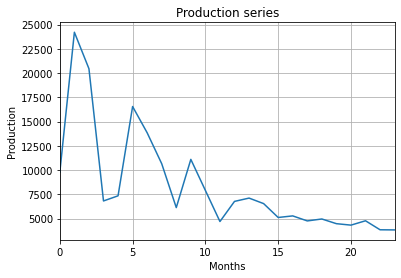

In [6]:
APIs = data['API'].unique()
plt.title('Production series')
plt.ylabel('Production')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data[data['API'] == APIs[0]]['Liquid']); 

In [7]:
dict_ = {}
for api in APIs:
    dict_[api] = list(data[data['API'] == api]['Liquid'])

df = pd.DataFrame(dict_)
df.head()

,5005072170100,5123377130000,5123379280000,5123379400000,5123385820100,5123390320000,5123390440000,5123392690000,5123399750000,5123402600000,5123409020000,5123410480000,30015414470000,30025425390000,33023010960000,33025026780000,33053048870100,33053051530000,33053056390200,33053056550000,33053059400000,33053061530000,33053061600000,33053061970000,33053062710000,33053067490000,33061032390000,33061033560000,33105031270000,33105032030000,33105034810000,33105035380000,33105035810000,33105036550100,33105037690100,35017246780000,35017246960000,35073250300000,42105419830000,42105420060100,42105421020000,42105421500000,42301318440000,42317401950000,42371392130100,42383381710000,42389339940000,42389345710000,42461395750000,49021210550000
0,9783,2341,6326,8644,1753,1115,7757,870,1119,9508,7741,1322,1269,10651,3781,0,34587,6542,13230,9608,23,14339,1700,26062,62,6749,7354,17985,12258,8131,1017,12975,3035,2105,572,3126,4,67,6219,14491,4189,6340,1113,14983,6199,1936,9852,9035,14193,1780
1,24206,4689,6405,13977,4402,2339,9725,5378,1513,13265,5880,9682,11831,19183,2781,601,23756,10012,9445,14664,4456,0,12269,16487,11348,23356,4445,15646,4806,15574,1997,23723,42,5086,573,3204,23,8647,3990,11336,3819,6560,0,9293,16092,12315,9866,19261,9657,6360
2,20449,3056,6839,9325,1187,5366,11541,5810,1217,8090,4261,6407,6876,36527,9377,13064,11248,4473,9344,9103,2238,0,5351,14996,5658,42345,6442,12933,4942,10629,0,0,9156,20181,21346,2406,12250,10815,1878,9149,3221,4112,996,10390,12077,11084,11728,14642,7796,7774
3,6820,1979,6584,6445,1204,3599,9506,6917,1265,6377,3226,4865,3781,22805,7891,28251,8767,21986,10960,8683,12456,0,2424,11193,8375,36323,5693,12245,4602,2335,0,12985,11875,12069,13527,1940,12231,6163,1719,7599,3769,4770,6860,7351,8846,7375,9368,12311,7036,10397
4,7349,2037,4775,5326,1176,2185,8121,5465,1402,5124,2777,2979,1470,16528,8480,20588,9780,18051,6598,11039,13359,16769,4712,9919,7055,25532,5148,8306,3398,1656,81,6102,5422,8045,14197,1711,10172,3085,1477,5445,3124,3133,4468,3203,8904,4606,11134,12088,6976,8189


# Continue with all APIs

In [222]:
train_window = 1

def create_inout_sequences(input_data, tw = 12):
    '''
    Divides the data to  those done befor train window and after
    in: input_data - input data (list)
        tw - train_window (int)
    out: tuple - 1st elem contains 12 records, 2nd contains 1 record
    '''
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [223]:
from sklearn.preprocessing import MinMaxScaler

all = {}
train_size = 12     ## you can choose the training size
train_data = {}
train_data_normalized = {}  ## normalize data with MinMaxScaler
train_inout_seq = {}        ## create sequence for training
scaler = {}                 ## scaler for each API

for i, api in enumerate(APIs):
    # all = df[5005072170100].values.astype(float)
    # all.append(df[api].values.astype(float))
    # train_data.append(all[i][:train_size])

    all[api] = df[api].values.astype(float)
    train_data[api] = all[api][:train_size]

    scaler[api] = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized[api] = scaler[api].fit_transform(train_data[api].reshape(-1, 1))
    train_data_normalized[api] = torch.FloatTensor(train_data_normalized[api]).view(-1)
    train_inout_seq[api] = create_inout_sequences(train_data_normalized[api], train_window)

In [224]:
pd.DataFrame(train_data_normalized)

,5005072170100,5123377130000,5123379280000,5123379400000,5123385820100,5123390320000,5123390440000,5123392690000,5123399750000,5123402600000,5123409020000,5123410480000,30015414470000,30025425390000,33023010960000,33025026780000,33053048870100,33053051530000,33053056390200,33053056550000,33053059400000,33053061530000,33053061600000,33053061970000,33053062710000,33053067490000,33061032390000,33061033560000,33105031270000,33105032030000,33105034810000,33105035380000,33105035810000,33105036550100,33105037690100,35017246780000,35017246960000,35073250300000,42105419830000,42105420060100,42105421020000,42105421500000,42301318440000,42317401950000,42371392130100,42383381710000,42389339940000,42389345710000,42461395750000,49021210550000
0,-0.478827,-0.356441,0.849978,0.123150,-0.360555,-1.000000,0.069584,-1.000000,-1.000000,0.433547,1.000000,-0.802501,-1.000000,-0.516764,-0.696786,-1.000000,1.000000,-0.763718,1.000000,0.065693,-1.000000,0.710180,-1.000000,1.000000,-1.000000,-0.681237,1.000000,1.000000,1.000000,-0.069550,-0.689276,0.093875,-0.491480,-1.000000,-0.990800,0.919045,-1.000000,-1.000000,1.000000,1.000000,1.000000,0.917153,-0.675510,1.000000,-0.694152,-1.000000,0.363096,-0.450291,1.000000,-0.686466
1,1.000000,1.000000,0.873081,1.000000,1.000000,-0.424136,0.553479,0.490987,-0.679153,1.000000,0.395092,1.000000,1.000000,-0.016647,-1.000000,-0.957453,0.182103,-0.367441,0.376287,1.000000,-0.335183,-1.000000,1.000000,0.238478,1.000000,0.103129,-0.072442,0.687967,-0.397468,1.000000,-0.389856,1.000000,-0.996457,-0.670170,-0.990704,1.000000,-0.996897,0.596576,0.179459,0.530086,0.695599,1.000000,-1.000000,0.183761,1.000000,1.000000,0.367849,1.000000,0.206299,0.209903
2,0.614785,0.056615,1.000000,0.235120,-0.651258,1.000000,1.000000,0.633868,-0.920195,0.219751,-0.131156,0.293877,0.061731,1.000000,1.000000,-0.075148,-0.762432,-1.000000,0.359644,-0.027626,-0.667816,-1.000000,-0.309112,0.119895,-0.008329,1.000000,0.663779,0.326041,-0.371964,0.289409,-1.000000,-1.000000,0.541252,1.000000,1.000000,0.171770,1.000000,1.000000,-0.598012,0.204349,0.203620,0.078140,-0.709621,0.341128,0.312441,0.762790,1.000000,0.344916,-0.119335,0.486643
3,-0.782631,-0.565569,0.925428,-0.238408,-0.642527,0.168666,0.499631,1.000000,-0.881108,-0.038522,-0.467577,-0.038594,-0.524333,0.195662,0.549424,1.000000,-0.949783,1.000000,0.625937,-0.105239,0.864577,-1.000000,-0.862996,-0.182567,0.473153,0.715574,0.387650,0.234258,-0.435724,-0.902429,-1.000000,0.094718,1.000000,0.102456,0.250695,-0.311884,0.996897,0.134351,-0.656543,-0.026512,0.654463,0.325927,1.000000,-0.094821,-0.240860,0.048078,0.198778,0.014324,-0.252318,1.000000
4,-0.728391,-0.532062,0.396403,-0.422394,-0.656908,-0.496589,0.159085,0.519762,-0.769544,-0.227441,-0.613522,-0.445235,-0.961939,-0.172274,0.728017,0.457506,-0.873287,0.550620,-0.092857,0.330130,1.000000,1.000000,-0.430031,-0.283891,0.239234,0.205904,0.186728,-0.291222,-0.661510,-1.000000,-0.975252,-0.485563,-0.088746,-0.342775,0.314902,-0.549559,0.660624,-0.438407,-0.745629,-0.347334,0.123817,-0.290529,0.302624,-0.689858,-0.230927,-0.485500,0.798336,-0.017303,-0.262817,0.567864
5,0.215216,-0.403235,0.145489,-0.551957,-0.478685,-0.354034,-0.175805,0.036878,0.517101,-0.382133,-0.909638,-1.000000,-0.404658,-0.129191,0.508187,0.188560,-0.806607,0.737795,-0.319272,-0.849949,0.437313,0.617508,-0.479232,-0.543246,-0.094631,0.013059,-0.063226,-0.228255,-0.710080,-0.718207,1.000000,0.338701,-0.365278,-0.355388,0.408625,-0.786196,0.739670,-0.385746,-0.800110,-0.826184,-0.208556,-0.443796,0.512828,-0.567637,-0.448069,-0.610752,0.391954,-0.482627,-0.512861,-0.202857
6,-0.062442,-0.575968,0.122971,-0.738573,-0.660503,-0.727123,-0.538972,0.143046,1.000000,-0.426461,-0.747765,-0.798620,-0.565423,-0.243552,0.085810,0.016601,-0.946536,0.251185,-0.431161,-0.424004,-0.094631,0.734510,-0.725423,-0.503480,-0.308524,-0.215208,-0.330507,-0.610993,-0.770839,-0.165397,0.434769,0.046495,-1.000000,-0.590507,0.040824,-0.661650,0.536665,-0.444734,-0.786858,-0.906911,0.070341

In [225]:
train_inout_seq[api]

[(tensor([-0.6865]), tensor([0.2099])),
 (tensor([0.2099]), tensor([0.4866])),
 (tensor([0.4866]), tensor([1.])),
 (tensor([1.]), tensor([0.5679])),
 (tensor([0.5679]), tensor([-0.2029])),
 (tensor([-0.2029]), tensor([-1.])),
 (tensor([-1.]), tensor([-0.1627])),
 (tensor([-0.1627]), tensor([-0.1463])),
 (tensor([-0.1463]), tensor([-0.3115])),
 (tensor([-0.3115]), tensor([-0.5870])),
 (tensor([-0.5870]), tensor([-0.4042]))]

# LSTM

In [226]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_layer_size = 100, output_size = 1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [284]:
model = LSTM()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0007)

In [285]:
epochs = 150
# fut_pred = 12
# seq = {}
# test_inputs = {}

model.train()
for api in APIs:
    print("{} / {}".format(np.where(APIs == api)[0][0], len(APIs)))
    # model = LSTM()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # loss_function = nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    # model.train()

    for i in range(epochs):
        for sequence, labels in train_inout_seq[api]:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(sequence)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        if i%25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    test_inputs[api] = train_data_normalized[api][-train_window:].tolist()

    # model.eval()

    # for i in range(fut_pred):
    #     seq[api] = torch.FloatTensor(test_inputs[api][-train_window:])
    #     with torch.no_grad():
    #         model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
    #                         torch.zeros(1, 1, model.hidden_layer_size))
    #         test_inputs[api].append(model(seq[api]).item())

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

0 / 50
epoch:   1 loss: 0.95556593
epoch:  26 loss: 0.46140048
epoch:  51 loss: 0.40739912
epoch:  76 loss: 0.39390543
epoch: 101 loss: 0.38688049
epoch: 126 loss: 0.38303551
1 / 50
epoch:   1 loss: 0.26322442
epoch:  26 loss: 0.05507191
epoch:  51 loss: 0.03987852
epoch:  76 loss: 0.02970834
epoch: 101 loss: 0.02124961
epoch: 126 loss: 0.01384243
2 / 50
epoch:   1 loss: 0.36024189
epoch:  26 loss: 0.32258368
epoch:  51 loss: 0.28749335
epoch:  76 loss: 0.24931704
epoch: 101 loss: 0.21508805
epoch: 126 loss: 0.18498327
3 / 50
epoch:   1 loss: 0.04995207
epoch:  26 loss: 0.00918137
epoch:  51 loss: 0.00473178
epoch:  76 loss: 0.00189630
epoch: 101 loss: 0.00042096
epoch: 126 loss: 0.00000021
4 / 50
epoch:   1 loss: 0.01424574
epoch:  26 loss: 0.02850109
epoch:  51 loss: 0.02545990
epoch:  76 loss: 0.01819273
epoch: 101 loss: 0.00895183
epoch: 126 loss: 0.00198661
5 / 50
epoch:   1 loss: 0.03063356
epoch:  26 loss: 0.04632700
epoch:  51 loss: 0.05319107
epoch:  76 loss: 0.05823515
epoch:

###### Evaluation

In [286]:
fut_pred = 12
test_inputs = {}
for api in APIs:
    test_inputs[api] = train_data_normalized[api][-train_window:].tolist()
print(test_inputs[5005072170100])

[-1.0]


In [287]:
model.eval()
seq = {}

for api in APIs:
    for i in range(fut_pred):
        seq[api] = torch.FloatTensor(test_inputs[api][-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs[api].append(model(seq[api]).item())

In [288]:
test_inputs[5005072170100]

[-1.0,
 -0.15163490176200867,
 -0.2646442949771881,
 -0.5044795870780945,
 -0.7373652458190918,
 -0.6875479221343994,
 -0.5923150181770325,
 -0.5880599021911621,
 -0.6094873547554016,
 -0.6160256862640381,
 -0.6097708940505981,
 -0.60527503490448,
 -0.6054465770721436]

In [289]:
actual_predictions = {}

for api in APIs:
    actual_predictions[api] = scaler[api].inverse_transform(np.array(test_inputs[api][train_window:] ).reshape(-1, 1))
print(actual_predictions[api])

# for api in APIs:
#     print(test_inputs[api][train_window:])

[[2263.62920231]
 [1787.68739977]
 [2085.60788932]
 [2275.97565657]
 [2243.16101044]
 [2175.54209349]
 [2165.95516616]
 [2185.79659426]
 [2195.02872092]
 [2191.89398846]
 [2188.28354901]
 [2188.35024545]]


In [290]:
x = np.arange(12, 24, 1)
print(x)

[12 13 14 15 16 17 18 19 20 21 22 23]


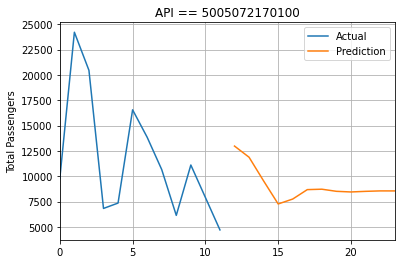

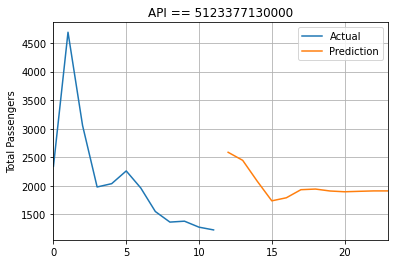

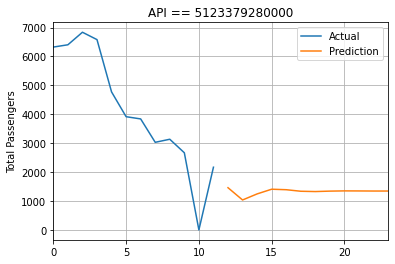

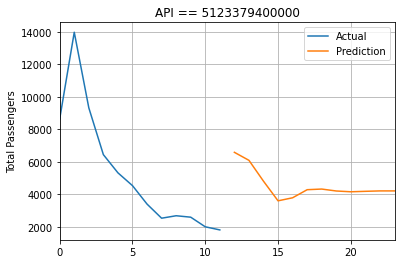

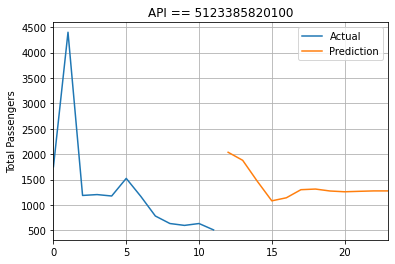

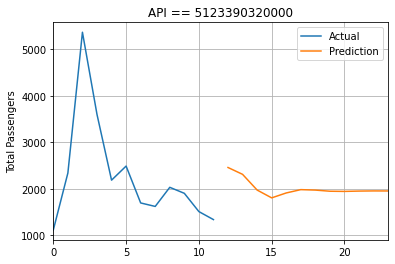

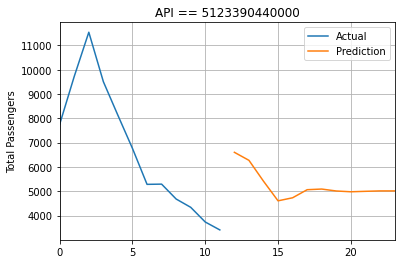

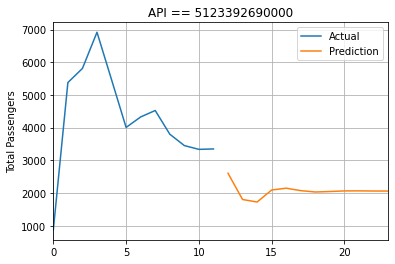

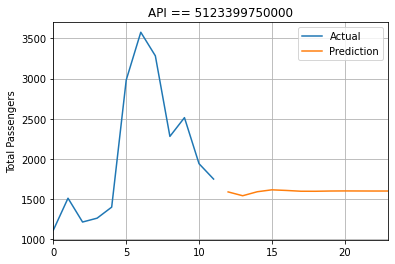

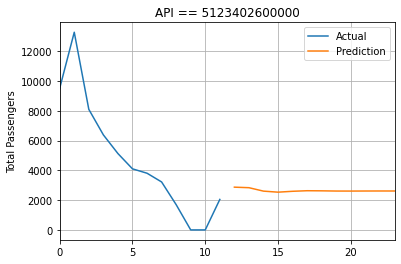

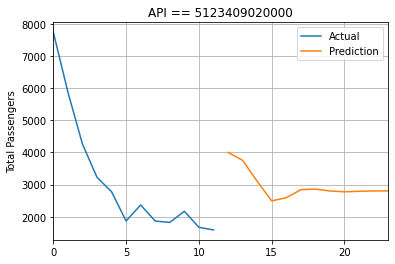

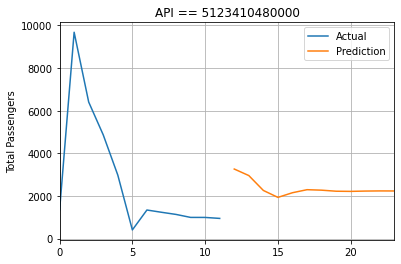

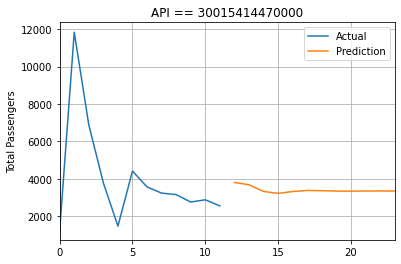

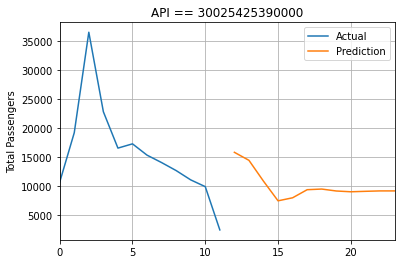

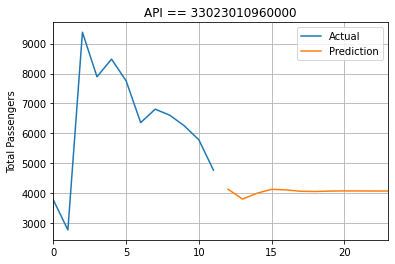

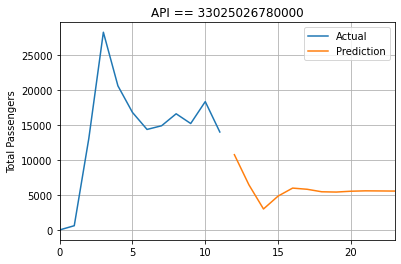

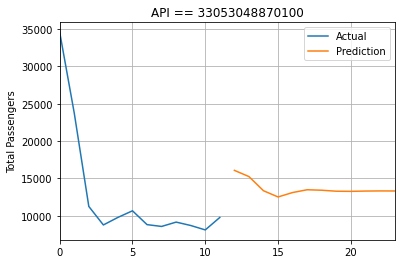

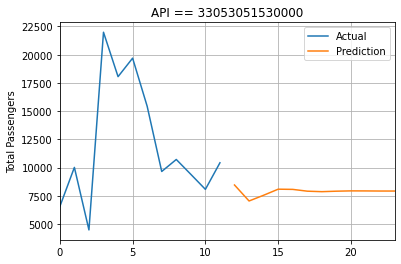

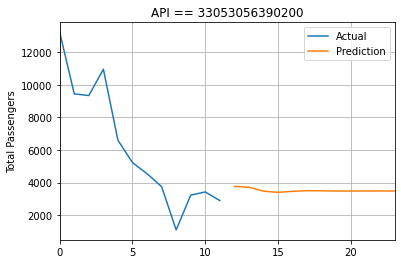

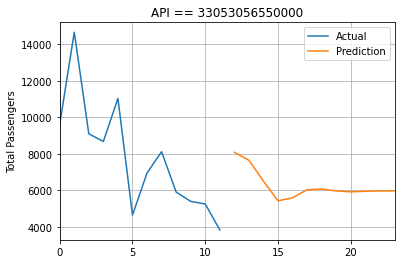

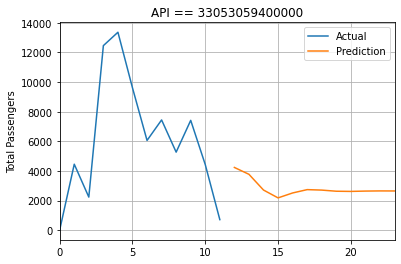

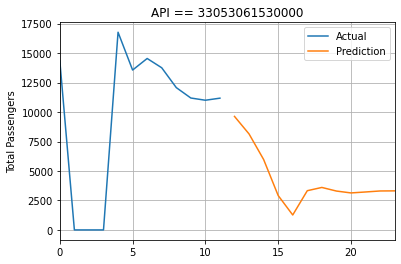

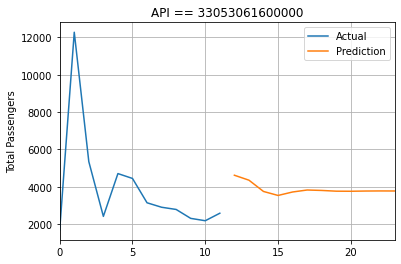

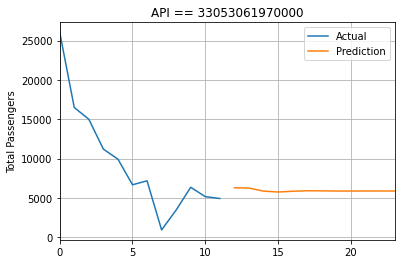

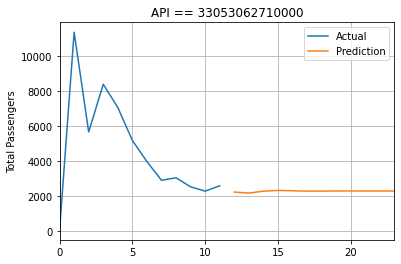

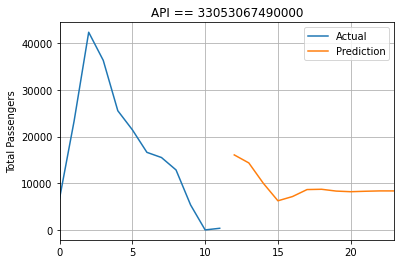

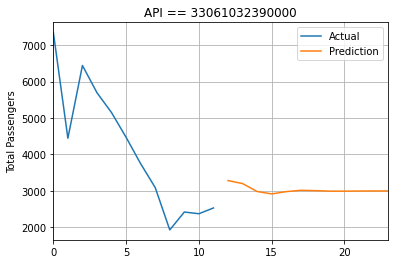

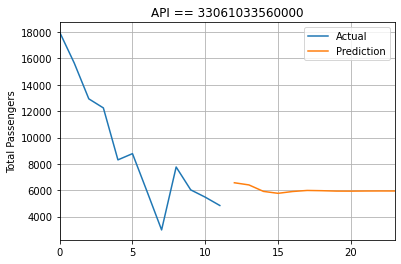

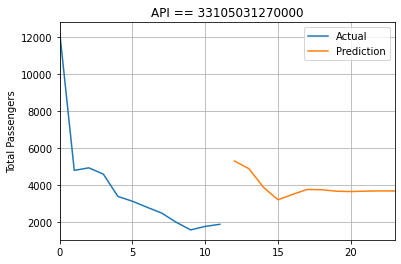

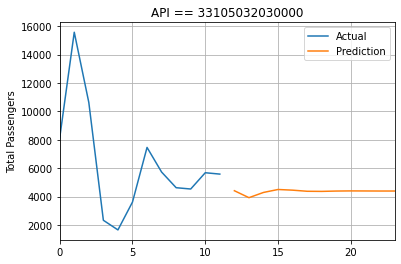

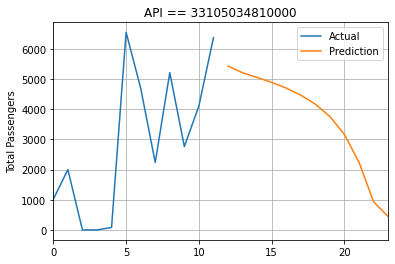

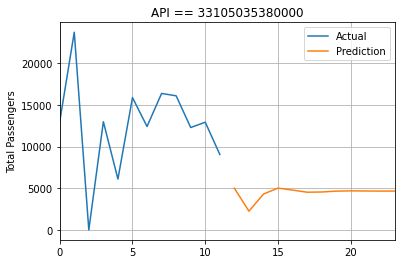

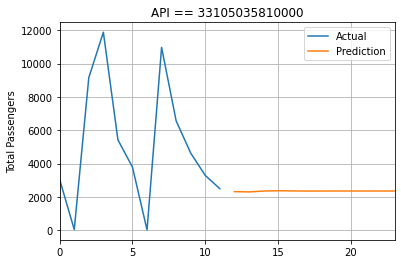

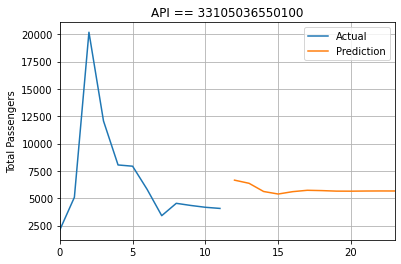

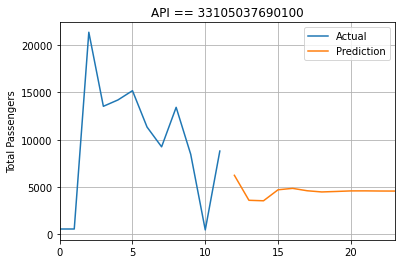

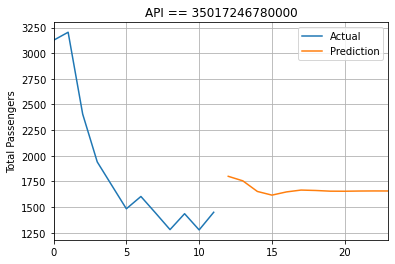

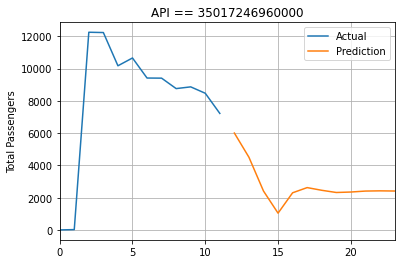

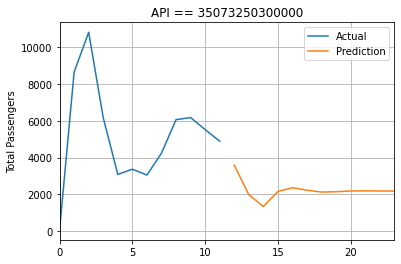

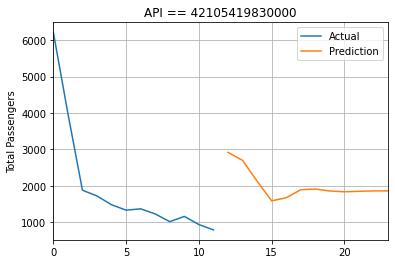

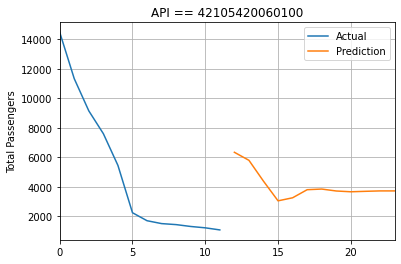

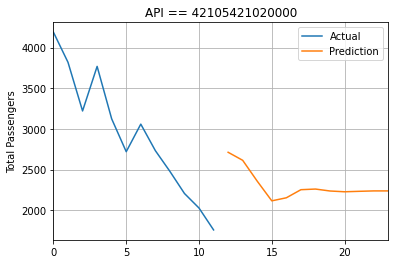

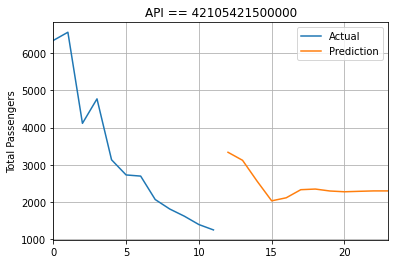

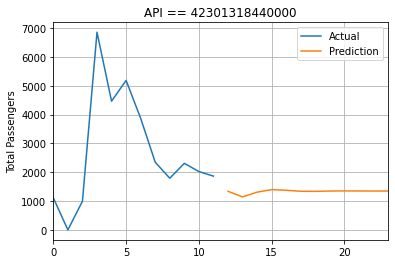

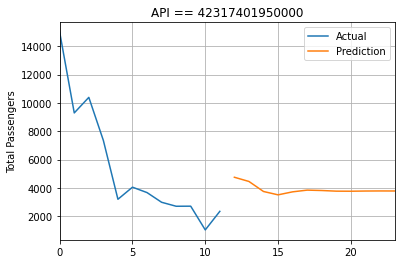

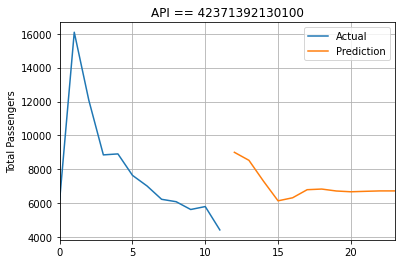

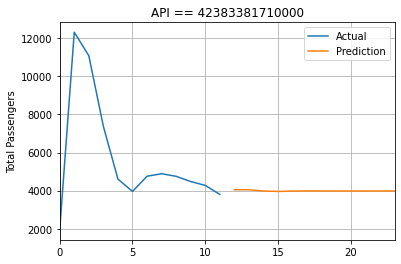

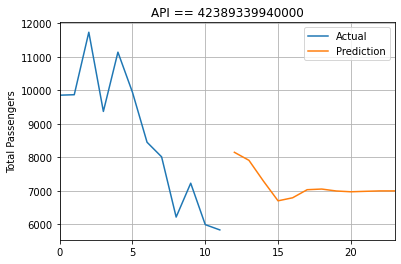

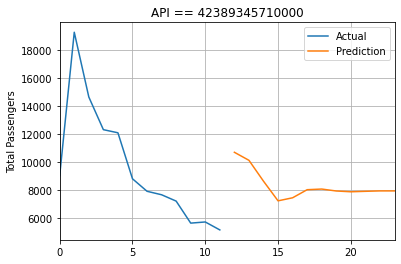

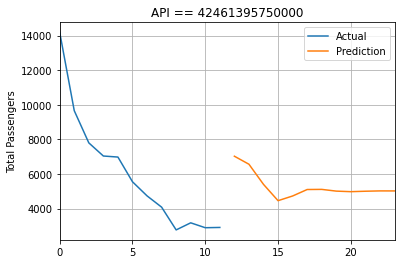

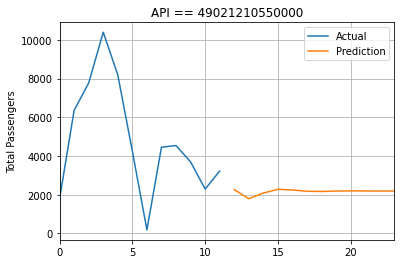

In [296]:
for api in APIs:

    plt.title(f'API == {api}')
    plt.ylabel('Total Passengers')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(df[api][:12], label = 'Actual')
    plt.plot(x,actual_predictions[api], label = 'Prediction')
    plt.legend()
    plt.show()

In [138]:
APIs

array([ 5005072170100,  5123377130000,  5123379280000,  5123379400000,
        5123385820100,  5123390320000,  5123390440000,  5123392690000,
        5123399750000,  5123402600000,  5123409020000,  5123410480000,
       30015414470000, 30025425390000, 33023010960000, 33025026780000,
       33053048870100, 33053051530000, 33053056390200, 33053056550000,
       33053059400000, 33053061530000, 33053061600000, 33053061970000,
       33053062710000, 33053067490000, 33061032390000, 33061033560000,
       33105031270000, 33105032030000, 33105034810000, 33105035380000,
       33105035810000, 33105036550100, 33105037690100, 35017246780000,
       35017246960000, 35073250300000, 42105419830000, 42105420060100,
       42105421020000, 42105421500000, 42301318440000, 42317401950000,
       42371392130100, 42383381710000, 42389339940000, 42389345710000,
       42461395750000, 49021210550000])